In [1]:
import seaborn as sns
import numpy as np
import scipy
import pandas as pd
import re
import researchpy as rp
import scikit_posthocs
import statsmodels.api as sm

from statsmodels.formula.api import ols
from glob import glob
from os.path import basename
from sklearn import metrics
from pingouin import kruskal
from scipy.stats import sem
from statsmodels.stats.anova import AnovaRM
from scipy.stats import friedmanchisquare

%matplotlib inline
import matplotlib.pyplot as plt

possible_blocks = np.array(['LetterTask10', 'LetterTask2', 'LetterTask3', 
                                'LetterTask4', 'LetterTask5', 'LetterTask6',
                                'LetterTask7', 'LetterTask8', 'LetterTask9',
                                'LetterTask19', 'LetterTask20', 'LetterTask21',
                                'LetterTask22', 'LetterTask23', 'LetterTask24', 
                                'LetterTask25', 'LetterTask26', 'LetterTask27', 
                                'LetterTask1', 'LetterTask11', 'LetterTask12', 
                                'LetterTask13', 'LetterTask14', 'LetterTask15', 
                                'LetterTask16', 'LetterTask17', 'LetterTask18' 
                            ])

possible_letters = np.array(['c', 'd', 'e', 'f', 'l', 'o', 'p', 't', 'z'])

num_subjects = 17

    

In [2]:
def parse_data(files):
    """Parse the raw data
    
    Parameters
    ----------
    files : list
        List of filenames to parse
    
    Returns
    -------
    df : pd.DataFrame
        A DataFrame containing letters and responses
    """
    df = []
    
    for file in files:
        subject = basename(file).split('_')[0]
        with open(file) as f:
            block = -1
            trial = -1
            while (line := f.readline().rstrip()):
                
                if '(' not in line:

                    for possible_block in range(len(possible_blocks)):
                        if line == possible_blocks[possible_block]:
                            block = possible_block
                    
                else:
                    # Else it's a trial string:
                    presented, remain = line.split(r', ')
                    chosen, remain = remain.split(r' - () ')
                    time, remain = re.split(r' seconds', remain)

                    # Add to a list of dicts, which will become our DataFrame:
                    df.append({
                        'subject': int(subject),
                        'block': int(block),
                        'presented': presented,
                        'chosen': chosen,
                        'time': float(time),
                   })

    return pd.DataFrame(df)

In [3]:
def annotate_data(dff):
    """Add device, rho, lam"""
    df = dff.copy()
    # block 0 is the practice rounds. 1-9 is the 6x10, 10-18 is  10x16 and 19-27 is the 19x31
    df['device'] = 'N/A'
    df.loc[(df.block >= 0) & (df.block <= 8), 'device'] = '06x10'
    df.loc[(df.block >= 9) & (df.block <= 17), 'device'] = '10x16'
    df.loc[(df.block >= 18) & (df.block <= 26), 'device'] = '19x31'
    
    
    # Each device has 9 entries: it's rho = 100 and the 3 lam, rho= 300 and the 3 lamdas,
    # then rho = 500 and the 3 lamdas.  
    rhos = np.array([['100'] * 3 + ['300'] * 3 + ['500'] * 3] * 3).flatten()
    lams = np.array(['0050', '1000', '5000'] * 9)
    df['rho'] = 'none'
    df['lam'] = 'none'
    for block in range(27):
        df.loc[df.block == block, 'rho'] = rhos[block]
        df.loc[df.block == block, 'lam'] = lams[block]

    return df

In [4]:
def check_data(df, label):
    fig, axes = plt.subplots(9, 3, figsize=(50,100), sharex=True, sharey=True)
    devices = np.sort(df['device'].unique())
    rhos = np.sort(df['rho'].unique())
    lams = np.sort(df['lam'].unique())

    for device in range(0,3):
        for rho in range(0,3):
            for lam in range(0,3):
                temp_df = df[(df['rho']==(rhos[rho])) & (df['device']==(devices[device])) & (df['lam']==(lams[lam]))]
                axes[rho+device*3, lam].hist(temp_df[label], bins=10)
                axes[rho+device*3, lam].set_title((devices[device], rhos[rho], lams[lam]), fontsize=40)
                fig.savefig(('distributions_'+label))


In [5]:
def get_F1(df):
    df_compact = []
    for key, data in df.groupby(['subject', 'device', 'rho', 'lam']):
        subj, dvc, rho, lam= key
        df_compact.append({
            'subject': subj,
            'device': dvc,
            'rho': rho,
            'lam': lam,
            'f1': metrics.f1_score(data['presented'], data['chosen'], average='macro'),
            'time': data['time'].mean()
        })
    df_compact = pd.DataFrame(df_compact)
    
    return df_compact

In [6]:
def get_F1_hmd(df):
    df_compact = []
    for key, data in df.groupby(['subject', 'device', 'rho', 'lam', 'hmd']):
        subj, dvc, rho, lam, hmd = key
        df_compact.append({
            'subject': subj,
            'device': dvc,
            'rho': rho,
            'lam': lam,
            'hmd': hmd,
            'f1': metrics.f1_score(data['presented'], data['chosen'], average='macro'),
            'time': data['time'].mean()
        })
    df_compact = pd.DataFrame(df_compact)
    
    return df_compact

In [7]:
def make_barplots_std(df, df2, label, ylabel):
    x = np.arange(3)
    width = .35

    fig, ax = plt.subplots(3, figsize=(15,15), sharey=True)

    df_coll_device = df.groupby('device')[label].agg([np.mean, np.std])
    df_coll_mean_device = df_coll_device.loc[:, 'mean'].values
    df_coll_std_device = df_coll_device.loc[:, 'std'].values

    df2_device = df2.groupby('device')[label].agg([np.mean, np.std])
    df2_coll_mean_device = df2_device.loc[:, 'mean'].values
    df2_coll_std_device = df2_device.loc[:, 'std'].values

    ax1 = ax[0].bar(x-.5*width, df_coll_mean_device, width, color = 'darkslategray', yerr=df_coll_std_device)
    ax2 = ax[0].bar(x+.5*width, df2_coll_mean_device, width, color = 'darkgray', yerr=df2_coll_std_device)
    plt.sca(ax[0])
    plt.xticks(range(3), ['6x10 Electrode Array', '10x16 Electrode Array', '19x31 Electrode Array'])
    plt.ylabel(ylabel)


    df_coll_rho = df.groupby('rho')[label].agg([np.mean, np.std])
    df_coll_mean_rho = df_coll_rho.loc[:, 'mean'].values
    df_coll_std_rho = df_coll_rho.loc[:, 'std'].values

    df2_rho = df2.groupby('rho')[label].agg([np.mean, np.std])
    df2_coll_mean_rho = df2_rho.loc[:, 'mean'].values
    df2_coll_std_rho = df2_rho.loc[:, 'std'].values

    ax3 = ax[1].bar(x-.5*width, df_coll_mean_rho, width, color = 'darkslategray', yerr=df_coll_std_rho)
    ax4 = ax[1].bar(x+.5*width, df2_coll_mean_rho, width, color = 'darkgray', yerr=df2_coll_std_rho)
    plt.sca(ax[1])
    plt.xticks(range(3), ['rho = 100', 'rho = 300', 'rho = 500'])
    plt.ylabel(ylabel)


    df_coll_lam = df.groupby('lam')[label].agg([np.mean, np.std])
    df_coll_mean_lam = df_coll_lam.loc[:, 'mean'].values
    df_coll_std_lam = df_coll_lam.loc[:, 'std'].values

    df2_lam = df2.groupby('lam')[label].agg([np.mean, np.std])
    df2_coll_mean_lam = df2_lam.loc[:, 'mean'].values
    df2_coll_std_lam = df2_lam.loc[:, 'std'].values

    ax5 = ax[2].bar(x-.5*width, df_coll_mean_lam, width, color = 'darkslategray', yerr=df_coll_std_lam)
    ax6 = ax[2].bar(x+.5*width, df2_coll_mean_lam, width, color = 'darkgray', yerr=df2_coll_std_lam)
    plt.sca(ax[2])
    plt.xticks(range(3), ['lambda = 50', 'lambda = 1000', 'lambda = 5000'])
    plt.ylabel(ylabel)


    plt.savefig('Letter_'+label+'_subplots.pdf', transparent=True)

In [8]:
### USES DUNN'S TEST TO FIND SIGNIFICANT PAIRINGS WITHIN GROUPS ###
def find_sig_pairings(df, value):
    groups = ['device', 'rho', 'lam']
    returnFrames = []
    for group in groups:
        results = scikit_posthocs.posthoc_dunn(df, value, group, p_adjust='holm')
        results.reset_index(inplace=True)
        #print(results)
        copy_df = results.copy()
        for col in results:
            if not col == 'index':
                results.loc[(results[col] < .001), col] = '***'
            for i in range(0, results.shape[0]):
                if (results[col].iloc[i] == '***'):
                    copy_df[col].iloc[i] = '***'
        results = scikit_posthocs.posthoc_dunn(df, value, group, p_adjust='holm')
        results.reset_index(inplace=True)
        for col in results:
            if not col == 'index':
                results.loc[(results[col] < .01), col] = '**'
            for i in range(0, results.shape[0]):
                if (results[col].iloc[i] == '**') and (copy_df[col].iloc[i] != '***'):
                    copy_df[col].iloc[i] = '**'
        results = scikit_posthocs.posthoc_dunn(df, value, group, p_adjust='holm')
        results.reset_index(inplace=True)
        for col in results:
            if not col == 'index':
                results.loc[(results[col] < .05), col] = '*'
            for i in range(0, results.shape[0]):
                if (results[col].iloc[i] == '*') and (copy_df[col].iloc[i] != '***') and (copy_df[col].iloc[i] != '**'):
                    copy_df[col].iloc[i] = '*'

        #print(copy_df)
        returnFrames.append(copy_df)
    return returnFrames

In [9]:
def grouped_boxplots(df, group):
    fig, ax= plt.subplots(figsize=[6.7, 7])
    df_hmd = df[df['hmd']=='headset']
    df_monitor = df[df['hmd']=='monitor']
    df_0 =  pd.DataFrame(df_hmd[df_hmd[group] == df_hmd[group].unique()[0]].f1).assign(group = df_monitor[group].unique()[0])
    df_0_m =  pd.DataFrame(df_monitor[df_monitor[group] == df_monitor[group].unique()[0]].f1).assign(group = df_monitor[group].unique()[0])
    df_0['m_f1'] = df_0_m['f1']
    
    df_1 =  pd.DataFrame(df_hmd[df_hmd[group] == df_hmd[group].unique()[1]].f1).assign(group = 1)
    df_1_m =  pd.DataFrame(df_monitor[df_monitor[group] == df_monitor[group].unique()[1]].f1).assign(group = 1)
    df_1['m_f1'] = df_1_m['f1']
    
    df_2 =  pd.DataFrame(df_hmd[df_hmd[group] == df_hmd[group].unique()[2]].f1).assign(group = 2)
    df_2_m =  pd.DataFrame(df_monitor[df_monitor[group] == df_monitor[group].unique()[2]].f1).assign(group = 2)
    df_2['m_f1'] = df_2_m['f1']

    cdf = pd.concat([df_0, df_1, df_2])
    mdf = pd.melt(cdf, id_vars=['group'], var_name=['F1'])
    sns.boxplot(x='group', y='value', hue='F1', data=mdf, palette='Greys')
    sns.stripplot(x='group', y='value', hue='F1', data=mdf, dodge=True, palette='Greys', jitter=.25, edgecolor='black', linewidth=.5, alpha=.6)
    plt.legend([],[], frameon = False)
    plt.ylabel('f1')
    fig.savefig('Letter_'+group+'_'+'_f1.pdf', transparent=True)

In [10]:
def grouped_boxplots_time(df, group):  
    fig, ax= plt.subplots(figsize=[6.7, 7])
    df_hmd = df[df['hmd']=='headset']
    df_monitor = df[df['hmd']=='monitor']
    df_0 =  pd.DataFrame(df_hmd[df_hmd[group] == df_hmd[group].unique()[0]].time).assign(group = df_monitor[group].unique()[0])
    df_0_m =  pd.DataFrame(df_monitor[df_monitor[group] == df_monitor[group].unique()[0]].time).assign(group = df_monitor[group].unique()[0])
    df_0['m_time'] = df_0_m['time']
    
    df_1 =  pd.DataFrame(df_hmd[df_hmd[group] == df_hmd[group].unique()[1]].time).assign(group = 1)
    df_1_m =  pd.DataFrame(df_monitor[df_monitor[group] == df_monitor[group].unique()[1]].time).assign(group = 1)
    df_1['m_time'] = df_1_m['time']
    
    df_2 =  pd.DataFrame(df_hmd[df_hmd[group] == df_hmd[group].unique()[2]].time).assign(group = 2)
    df_2_m =  pd.DataFrame(df_monitor[df_monitor[group] == df_monitor[group].unique()[2]].time).assign(group = 2)
    print(rp.summary_cont(df_2))
    df_2['m_time'] = df_2_m['time']
    print(rp.summary_cont(df_2))

    cdf = pd.concat([df_0, df_1, df_2])
    print(rp.summary_cont(df_2_m))
    mdf = pd.melt(cdf, id_vars=['group'], var_name=['time'])
    
    sns.boxplot(x='group', y='value', hue='time', data=mdf, palette='Greys')
    sns.stripplot(x='group', y='value', hue='time', data=mdf, dodge=True, palette='Greys', jitter=.25, edgecolor='black', linewidth=.5, alpha=.6)
    plt.legend([],[], frameon = False)
    plt.ylabel('time')
    fig.savefig('Letter_'+group+'_'+'_time.pdf', transparent=True)


In [11]:
def generate_all(df):
    for value in ['f1', 'time']:
        for group in ['device', 'rho', 'lam']:
            grouped_boxplots(df, group)
            grouped_boxplots_time(df,group)

In [70]:
def chart_values_combo(df):
    print("\\begin{table}[ht]\n\t\\centering\n\t\\begin{tabular}{|c|c|c|c|c|c|}")
    print("\t\t\hline\n\t\tCondition & F1 Score ($\\pm$ Std Dev)  & F1 Score ($\\pm$ Std Dev) & Mean Time (s) ",
          "($\\pm$ Std Dev) & Mean Time (s) ($\\pm$ Std Dev)\\\\\n",
          "\t\t & HMD & Monitor & HMD & Monitor  \\\\\n\t\t\\hline")
    for value in ['device', 'rho', 'lam']:
        for uni in df[value].unique():
            if 'headset' in uni:
                match=df[df[value]==uni]['f1']
                t_match=df[df[value]==uni]['time']
               
                metric = uni[8:]
                m_match = df[df[value]=='monitor_'+metric]['f1']
                m_t_match = df[df[value]=='monitor_'+metric]['time']
                
                if metric == '06x10':
                    metric = '06x10 Array'
                elif metric == '10x16':
                    metric = '10x16 Array'
                elif metric == '19x31':
                    metric = '19x31 Array'            
                elif metric == '100':
                    metric = '\\ac{rho}=100'
                elif metric == '300':
                    metric = '\\ac{rho}=300'
                elif metric == '500':
                    metric = '\\ac{rho}=500'            
                elif metric == '0050':
                    metric = '\\ac{lambda}=50'
                elif metric == '1000':
                    metric = '\\ac{lambda}=1000'
                elif metric == '5000':
                    metric = '\\ac{lambda}=5000'
                print("\t\t\\hline")
                
                print("\t\t", metric, " & ", "{:.3f}".format(match.mean()), "($\\pm$", "{:.3f}".format(match.std()), 
                      ")  &  ", "{:.3f}".format(m_match.mean()), "($\\pm$", "{:.3f}".format(m_match.std()),
                      ") & ", "{:.3f}".format(t_match.mean()), " ($\\pm$", "{:.3f}".format(t_match.std()),
                      ")  &  ", "{:.3f}".format(m_t_match.mean()), " ($\\pm$", "{:.3f}".format(m_t_match.std()), ") \\\\")
                print("\t\t\\hline")
                
#                 print("\t\t", metric, " & ", "{:.3f}".format(match.mean()), "(\\pm", "{:.3f}".format(match.std()), 
#                       ")  /  ", "{:.3f}".format(m_match.mean()), "(\\pm", "{:.3f}".format(m_match.std()),
#                       ") & ", "{:.3f}".format(match.median()), "  /  ", "{:.3f}".format(m_match.median()), 
#                       " & ", "{:.3f}".format(t_match.mean()), " (\\pm", "{:.3f}".format(t_match.std()),
#                       ")  /  ", "{:.3f}".format(m_t_match.mean()), " (\\pm", "{:.3f}".format(m_t_match.std()),
#                       ") & ", "{:.3f}".format(t_match.median()), "  /  ", "{:.3f}".format(m_t_match.median()), " \\\\")
#                 print("\t\t\\hline")
            
    print("\t\\end{tabular}")
    print("\t\\caption{Average performance and time across conditions}")
    print("\t\\label{tab:average-letter}")
    print("\end{table}")
        
            

In [69]:
chart_values_combo(df_annot)

\begin{table}[ht]
	\centering
	\begin{tabular}{|c|c|c|c|c|c|}
		\hline
		Condition & F1 Score ($\pm$ Std Dev)  & F1 Score ($\pm$ Std Dev) & Mean Time (s)  ($\pm$ Std Dev) & Mean Time (s) ($\pm$ Std Dev)\\
 		 & HMD & Monitor & HMD & Monitor  \\
		\hline
		\hline
		 06x10 Array  &  0.411 ($\pm$ 0.341 )  &   0.344 ($\pm$ 0.339 ) &  8.312  ($\pm$ 5.685 )  &   7.979  ($\pm$ 7.367 ) \\
		\hline
		 10x16 Array  &  0.628 ($\pm$ 0.361 )  &   0.546 ($\pm$ 0.380 ) &  5.853  ($\pm$ 4.808 )  &   5.567  ($\pm$ 3.608 ) \\
		\hline
		 19x31 Array  &  0.699 ($\pm$ 0.347 )  &   0.596 ($\pm$ 0.373 ) &  5.379  ($\pm$ 4.164 )  &   5.661  ($\pm$ 4.373 ) \\
		\hline
		 \ac{rho}=100  &  0.570 ($\pm$ 0.388 )  &   0.467 ($\pm$ 0.381 ) &  7.415  ($\pm$ 5.874 )  &   7.007  ($\pm$ 6.120 ) \\
		\hline
		 \ac{rho}=300  &  0.620 ($\pm$ 0.366 )  &   0.540 ($\pm$ 0.379 ) &  6.173  ($\pm$ 4.879 )  &   5.829  ($\pm$ 4.686 ) \\
		\hline
		 \ac{rho}=500  &  0.548 ($\pm$ 0.352 )  &   0.479 ($\pm$ 0.377 ) &  5.956  ($\pm$ 4

In [13]:
files = glob('LetterHMD/*.csv')
df_raw = parse_data(files)

files = glob('LetterMonitor/*.csv')
df_raw_m = parse_data(files)

In [14]:
# rp.summary_cat(df_raw[['presented', 'chosen']])

In [15]:
# rp.summary_cat(df_raw_m[['presented', 'chosen']])

In [16]:
df_annot_h = get_F1(annotate_data(df_raw))

df_annot_m = get_F1(annotate_data(df_raw_m))

In [17]:
### CHECK DATA FOR INCONSISTENCIES

# rp.summary_cat(df_annot_h[["device", "rho", "lam"]])  #independent variables

In [18]:
# rp.summary_cont(df_annot_h[["f1"]])  #independent variables

In [19]:
# rp.summary_cont(df_annot_h[["time"]])

In [20]:
# rp.summary_cat(df_annot_m[["device", "rho", "lam"]])  #independent variables

In [21]:
# rp.summary_cont(df_annot_h[["f1"]])  #independent variables

In [22]:
# rp.summary_cont(df_annot_h[["time"]])

In [23]:
### CHECK FOR NORMAL DISTRIBUTION IN DATASET
# check_data(df_annot_h, 'f1')

In [24]:
# check_data(df_annot_h, 'time')

In [25]:
# check_data(df_annot_m, 'f1')

In [26]:
# check_data(df_annot_m, 'time')

In [27]:
### COMBINE DATASETS TO COMPARE ACROSS DEVICES ###

df_annot_h['device'] = 'headset_'+ df_annot_h['device']
df_annot_h['rho'] = 'headset_'+ df_annot_h['rho']
df_annot_h['lam'] = 'headset_'+ df_annot_h['lam']
df_annot_h['hmd'] = 'headset'

df_annot_m['device'] = 'monitor_'+ df_annot_m['device']
df_annot_m['rho'] = 'monitor_'+ df_annot_m['rho']
df_annot_m['lam'] = 'monitor_'+ df_annot_m['lam']
df_annot_m['hmd'] = 'monitor'

df_annot = pd.concat([df_annot_h, df_annot_m])

In [28]:
output_csv = pd.DataFrame()
output_csv['Subject'] = df_annot['subject'].astype(int)
output_csv['Subject'] = output_csv['Subject'].astype(str)
output_csv['Device'] = df_annot['device']
output_csv['Rho'] = df_annot['rho']
output_csv['Lambda'] =  df_annot['lam']
output_csv['Display'] = df_annot['hmd']
output_csv['Time'] = df_annot['time']
output_csv.to_csv('ltime.csv', index=False)

output_csv
rp.summary_cat(output_csv[['Device', 'Rho', 'Lambda', 'Display']])

,Variable,Outcome,Count,Percent
0,Device,headset_06x10,153,16.67
1,,monitor_06x10,153,16.67
2,,headset_10x16,153,16.67
3,,headset_19x31,153,16.67
4,,monitor_19x31,153,16.67
5,,monitor_10x16,153,16.67
6,Rho,monitor_300,153,16.67
7,,headset_300,153,16.67
8,,headset_100,153,16.67
9,,headset_500,153,16.67


In [29]:
# DATA NOT NORMALLY DISTRIBUTED, USE NON-PARAMETRIC ANALYSES
# PERFORM SIGNIFICANCE TESTING FOR GROUPS WITHIN HEADSET/MONITOR DATASETS

groups = ['device', 'rho', 'lam']

# Friedman test TO CONFIRM SIGNIFICANT GROUPS
for group in groups:
    c = []
    for a in df_annot[group].unique():
        b = df_annot[df_annot[group]==a]
        c.append(np.array(b.f1))
    results = friedmanchisquare(c[0], c[1], c[2])
    print(group , ': ' , results)


device :  FriedmanchisquareResult(statistic=94.58382642998026, pvalue=2.893230615691446e-21)
rho :  FriedmanchisquareResult(statistic=15.965141612200568, pvalue=0.00034136072128906415)
lam :  FriedmanchisquareResult(statistic=227.66906474820144, pvalue=3.649982144269835e-50)


In [30]:
devPairs, rhoPairs, lamPairs = find_sig_pairings(df_annot, 'f1')
devPairs

c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

,index,headset_06x10,headset_10x16,headset_19x31,monitor_06x10,monitor_10x16,monitor_19x31
0,headset_06x10,1.0,***,***,0.307956,*,***
1,headset_10x16,***,1.0,0.307956,***,0.307956,0.5886
2,headset_19x31,***,0.307956,1.0,***,**,0.104052
3,monitor_06x10,0.307956,***,***,1.0,***,***
4,monitor_10x16,*,0.307956,**,***,1.0,0.368117
5,monitor_19x31,***,0.5886,0.104052,***,0.368117,1.0


In [31]:
rhoPairs

,index,headset_100,headset_300,headset_500,monitor_100,monitor_300,monitor_500
0,headset_100,1.000000,1.0,1.000000,0.259716,1.000000,0.431216
1,headset_300,1.000000,1.0,0.728970,**,0.474866,*
2,headset_500,1.000000,0.72897,1.000000,0.67493,1.000000,0.878058
3,monitor_100,0.259716,**,0.674930,1.0,0.878058,1.0
4,monitor_300,1.000000,0.474866,1.000000,0.878058,1.000000,1.0
5,monitor_500,0.431216,*,0.878058,1.0,1.000000,1.0


In [32]:
lamPairs

,index,headset_0050,headset_1000,headset_5000,monitor_0050,monitor_1000,monitor_5000
0,headset_0050,1.0,**,***,0.172859,***,***
1,headset_1000,**,1.0,***,0.150955,*,***
2,headset_5000,***,***,1.0,***,***,0.206237
3,monitor_0050,0.172859,0.150955,***,1.0,***,***
4,monitor_1000,***,*,***,***,1.0,***
5,monitor_5000,***,***,0.206237,***,***,1.0


In [33]:
# PERFORM FOR TIME
for group in groups:
    c = []
    for a in df_annot[group].unique():
        b = df_annot[df_annot[group]==a]
        c.append(np.array(b.time))
    results = friedmanchisquare(c[0], c[1], c[2])
    print(group , ': ' , results)


device :  FriedmanchisquareResult(statistic=74.75816993464059, pvalue=5.840764019724114e-17)
rho :  FriedmanchisquareResult(statistic=12.95424836601319, pvalue=0.0015382279867802756)
lam :  FriedmanchisquareResult(statistic=81.45098039215691, pvalue=2.0565739718380115e-18)


In [34]:
devPairs, rhoPairs, lamPairs = find_sig_pairings(df_annot, 'time')
devPairs

c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

,index,headset_06x10,headset_10x16,headset_19x31,monitor_06x10,monitor_10x16,monitor_19x31
0,headset_06x10,1.0,***,***,0.848065,***,***
1,headset_10x16,***,1.0,1.0,*,1.0,1.0
2,headset_19x31,***,1.0,1.0,**,1.0,1.0
3,monitor_06x10,0.848065,*,**,1.0,0.102419,*
4,monitor_10x16,***,1.0,1.0,0.102419,1.0,1.0
5,monitor_19x31,***,1.0,1.0,*,1.0,1.0


In [35]:
rhoPairs

,index,headset_100,headset_300,headset_500,monitor_100,monitor_300,monitor_500
0,headset_100,1.000000,0.73372,1.0,1.00000,0.501286,1.0
1,headset_300,0.733720,1.00000,1.0,1.00000,1.000000,1.0
2,headset_500,1.000000,1.00000,1.0,1.00000,1.000000,1.0
3,monitor_100,1.000000,1.00000,1.0,1.00000,0.890040,1.0
4,monitor_300,0.501286,1.00000,1.0,0.89004,1.000000,1.0
5,monitor_500,1.000000,1.00000,1.0,1.00000,1.000000,1.0


In [36]:
lamPairs

,index,headset_0050,headset_1000,headset_5000,monitor_0050,monitor_1000,monitor_5000
0,headset_0050,1.0,0.094034,***,0.594026,*,***
1,headset_1000,0.094034,1.0,***,0.594026,0.594026,***
2,headset_5000,***,***,1.0,***,***,0.255169
3,monitor_0050,0.594026,0.594026,***,1.0,0.216879,***
4,monitor_1000,*,0.594026,***,0.216879,1.0,**
5,monitor_5000,***,***,0.255169,***,**,1.0


In [37]:
# Repeat for significance values without erroneous h -> monitor comparisons (e.g. h Rho100 vs Monitor Rho 300)
for group in groups:
    c = []
    for a in df_annot_h[group].unique():
        b = df_annot_h[df_annot_h[group]==a]
        c.append(np.array(b.f1))
    results = friedmanchisquare(c[0], c[1], c[2])
    print(group , ': ' , results)


device :  FriedmanchisquareResult(statistic=94.58382642998026, pvalue=2.893230615691446e-21)
rho :  FriedmanchisquareResult(statistic=15.965141612200568, pvalue=0.00034136072128906415)
lam :  FriedmanchisquareResult(statistic=227.66906474820144, pvalue=3.649982144269835e-50)


In [38]:
devPairs, rhoPairs, lamPairs = find_sig_pairings(df_annot, 'f1')
devPairs

c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

,index,headset_06x10,headset_10x16,headset_19x31,monitor_06x10,monitor_10x16,monitor_19x31
0,headset_06x10,1.0,***,***,0.307956,*,***
1,headset_10x16,***,1.0,0.307956,***,0.307956,0.5886
2,headset_19x31,***,0.307956,1.0,***,**,0.104052
3,monitor_06x10,0.307956,***,***,1.0,***,***
4,monitor_10x16,*,0.307956,**,***,1.0,0.368117
5,monitor_19x31,***,0.5886,0.104052,***,0.368117,1.0


In [39]:
rhoPairs

,index,headset_100,headset_300,headset_500,monitor_100,monitor_300,monitor_500
0,headset_100,1.000000,1.0,1.000000,0.259716,1.000000,0.431216
1,headset_300,1.000000,1.0,0.728970,**,0.474866,*
2,headset_500,1.000000,0.72897,1.000000,0.67493,1.000000,0.878058
3,monitor_100,0.259716,**,0.674930,1.0,0.878058,1.0
4,monitor_300,1.000000,0.474866,1.000000,0.878058,1.000000,1.0
5,monitor_500,0.431216,*,0.878058,1.0,1.000000,1.0


In [40]:
lamPairs

,index,headset_0050,headset_1000,headset_5000,monitor_0050,monitor_1000,monitor_5000
0,headset_0050,1.0,**,***,0.172859,***,***
1,headset_1000,**,1.0,***,0.150955,*,***
2,headset_5000,***,***,1.0,***,***,0.206237
3,monitor_0050,0.172859,0.150955,***,1.0,***,***
4,monitor_1000,***,*,***,***,1.0,***
5,monitor_5000,***,***,0.206237,***,***,1.0


In [41]:
for group in groups:
    c = []
    for a in df_annot_h[group].unique():
        b = df_annot_h[df_annot_h[group]==a]
        c.append(np.array(b.time))
    results = friedmanchisquare(c[0], c[1], c[2])
    print(group , ': ' , results)


device :  FriedmanchisquareResult(statistic=74.75816993464059, pvalue=5.840764019724114e-17)
rho :  FriedmanchisquareResult(statistic=12.95424836601319, pvalue=0.0015382279867802756)
lam :  FriedmanchisquareResult(statistic=81.45098039215691, pvalue=2.0565739718380115e-18)


In [42]:
devPairs, rhoPairs, lamPairs = find_sig_pairings(df_annot, 'f1')
devPairs

c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

,index,headset_06x10,headset_10x16,headset_19x31,monitor_06x10,monitor_10x16,monitor_19x31
0,headset_06x10,1.0,***,***,0.307956,*,***
1,headset_10x16,***,1.0,0.307956,***,0.307956,0.5886
2,headset_19x31,***,0.307956,1.0,***,**,0.104052
3,monitor_06x10,0.307956,***,***,1.0,***,***
4,monitor_10x16,*,0.307956,**,***,1.0,0.368117
5,monitor_19x31,***,0.5886,0.104052,***,0.368117,1.0


In [43]:
rhoPairs

,index,headset_100,headset_300,headset_500,monitor_100,monitor_300,monitor_500
0,headset_100,1.000000,1.0,1.000000,0.259716,1.000000,0.431216
1,headset_300,1.000000,1.0,0.728970,**,0.474866,*
2,headset_500,1.000000,0.72897,1.000000,0.67493,1.000000,0.878058
3,monitor_100,0.259716,**,0.674930,1.0,0.878058,1.0
4,monitor_300,1.000000,0.474866,1.000000,0.878058,1.000000,1.0
5,monitor_500,0.431216,*,0.878058,1.0,1.000000,1.0


In [44]:
lamPairs

,index,headset_0050,headset_1000,headset_5000,monitor_0050,monitor_1000,monitor_5000
0,headset_0050,1.0,**,***,0.172859,***,***
1,headset_1000,**,1.0,***,0.150955,*,***
2,headset_5000,***,***,1.0,***,***,0.206237
3,monitor_0050,0.172859,0.150955,***,1.0,***,***
4,monitor_1000,***,*,***,***,1.0,***
5,monitor_5000,***,***,0.206237,***,***,1.0


In [45]:
for group in groups:
    c = []
    for a in df_annot_m[group].unique():
        b = df_annot_m[df_annot_m[group]==a]
        c.append(np.array(b.f1))
    results = friedmanchisquare(c[0], c[1], c[2])
    print(group , ': ' , results)


device :  FriedmanchisquareResult(statistic=75.70769230769231, pvalue=3.6331514041194206e-17)
rho :  FriedmanchisquareResult(statistic=4.865853658536685, pvalue=0.08777954051272896)
lam :  FriedmanchisquareResult(statistic=156.77522123893806, pvalue=9.05093109027044e-35)


In [46]:
devPairs, rhoPairs, lamPairs = find_sig_pairings(df_annot_m, 'f1')
devPairs

c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

,index,monitor_06x10,monitor_10x16,monitor_19x31
0,monitor_06x10,1.0,***,***
1,monitor_10x16,***,1.0,0.187862
2,monitor_19x31,***,0.187862,1.0


In [47]:
rhoPairs

,index,monitor_100,monitor_300,monitor_500
0,monitor_100,1.000000,0.382330,0.803686
1,monitor_300,0.382330,1.000000,0.404136
2,monitor_500,0.803686,0.404136,1.000000


In [48]:
lamPairs

,index,monitor_0050,monitor_1000,monitor_5000
0,monitor_0050,1.0,***,***
1,monitor_1000,***,1.0,***
2,monitor_5000,***,***,1.0


In [49]:
for group in groups:
    c = []
    for a in df_annot_m[group].unique():
        b = df_annot_m[df_annot_m[group]==a]
        c.append(np.array(b.time))
    results = friedmanchisquare(c[0], c[1], c[2])
    print(group , ': ' , results)


device :  FriedmanchisquareResult(statistic=29.228758169934736, pvalue=4.498376554378243e-07)
rho :  FriedmanchisquareResult(statistic=10.509803921568619, pvalue=0.005221858213767797)
lam :  FriedmanchisquareResult(statistic=54.52287581699352, pvalue=1.4471313353650885e-12)


In [50]:
devPairs, rhoPairs, lamPairs = find_sig_pairings(df_annot_m, 'f1')
devPairs

c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

,index,monitor_06x10,monitor_10x16,monitor_19x31
0,monitor_06x10,1.0,***,***
1,monitor_10x16,***,1.0,0.187862
2,monitor_19x31,***,0.187862,1.0


In [51]:
rhoPairs

,index,monitor_100,monitor_300,monitor_500
0,monitor_100,1.000000,0.382330,0.803686
1,monitor_300,0.382330,1.000000,0.404136
2,monitor_500,0.803686,0.404136,1.000000


In [52]:
lamPairs

,index,monitor_0050,monitor_1000,monitor_5000
0,monitor_0050,1.0,***,***
1,monitor_1000,***,1.0,***
2,monitor_5000,***,***,1.0


c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * sc



  Variable      N    Mean     SD      SE  95% Conf.  Interval
0     time  153.0  5.3792  4.164  0.3366     4.7141    6.0443
1    group  153.0  2.0000  0.000  0.0000        NaN       NaN


  Variable      N    Mean      SD      SE  95% Conf.  Interval
0     time  153.0  5.3792  4.1640  0.3366     4.7141    6.0443
1    group  153.0  2.0000  0.0000  0.0000        NaN       NaN
2   m_time  153.0  5.6611  4.3728  0.3535     4.9627    6.3595


  Variable      N    Mean      SD      SE  95% Conf.  Interval
0     time  153.0  5.6611  4.3728  0.3535     4.9627    6.3595
1    group  153.0  2.0000  0.0000  0.0000        NaN       NaN


c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * sc



  Variable      N   Mean      SD     SE  95% Conf.  Interval
0     time  153.0  5.956  4.2669  0.345     5.2744    6.6375
1    group  153.0  2.000  0.0000  0.000        NaN       NaN


  Variable      N    Mean      SD      SE  95% Conf.  Interval
0     time  153.0  5.9560  4.2669  0.3450     5.2744    6.6375
1    group  153.0  2.0000  0.0000  0.0000        NaN       NaN
2   m_time  153.0  6.3714  5.4827  0.4433     5.4957    7.2472


  Variable      N    Mean      SD      SE  95% Conf.  Interval
0     time  153.0  6.3714  5.4827  0.4433     5.4957    7.2472
1    group  153.0  2.0000  0.0000  0.0000        NaN       NaN


c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * sc



  Variable      N    Mean      SD      SE  95% Conf.  Interval
0     time  153.0  9.3065  5.9064  0.4775     8.3631   10.2499
1    group  153.0  2.0000  0.0000  0.0000        NaN       NaN


  Variable      N    Mean      SD      SE  95% Conf.  Interval
0     time  153.0  9.3065  5.9064  0.4775     8.3631   10.2499
1    group  153.0  2.0000  0.0000  0.0000        NaN       NaN
2   m_time  153.0  8.0987  5.7000  0.4608     7.1883    9.0091


  Variable      N    Mean   SD      SE  95% Conf.  Interval
0     time  153.0  8.0987  5.7  0.4608     7.1883    9.0091
1    group  153.0  2.0000  0.0  0.0000        NaN       NaN


c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * sc



  Variable      N    Mean     SD      SE  95% Conf.  Interval
0     time  153.0  5.3792  4.164  0.3366     4.7141    6.0443
1    group  153.0  2.0000  0.000  0.0000        NaN       NaN


  Variable      N    Mean      SD      SE  95% Conf.  Interval
0     time  153.0  5.3792  4.1640  0.3366     4.7141    6.0443
1    group  153.0  2.0000  0.0000  0.0000        NaN       NaN
2   m_time  153.0  5.6611  4.3728  0.3535     4.9627    6.3595


  Variable      N    Mean      SD      SE  95% Conf.  Interval
0     time  153.0  5.6611  4.3728  0.3535     4.9627    6.3595
1    group  153.0  2.0000  0.0000  0.0000        NaN       NaN


c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * sc



  Variable      N   Mean      SD     SE  95% Conf.  Interval
0     time  153.0  5.956  4.2669  0.345     5.2744    6.6375
1    group  153.0  2.000  0.0000  0.000        NaN       NaN


  Variable      N    Mean      SD      SE  95% Conf.  Interval
0     time  153.0  5.9560  4.2669  0.3450     5.2744    6.6375
1    group  153.0  2.0000  0.0000  0.0000        NaN       NaN
2   m_time  153.0  6.3714  5.4827  0.4433     5.4957    7.2472


  Variable      N    Mean      SD      SE  95% Conf.  Interval
0     time  153.0  6.3714  5.4827  0.4433     5.4957    7.2472
1    group  153.0  2.0000  0.0000  0.0000        NaN       NaN


c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * sc



  Variable      N    Mean      SD      SE  95% Conf.  Interval
0     time  153.0  9.3065  5.9064  0.4775     8.3631   10.2499
1    group  153.0  2.0000  0.0000  0.0000        NaN       NaN


  Variable      N    Mean      SD      SE  95% Conf.  Interval
0     time  153.0  9.3065  5.9064  0.4775     8.3631   10.2499
1    group  153.0  2.0000  0.0000  0.0000        NaN       NaN
2   m_time  153.0  8.0987  5.7000  0.4608     7.1883    9.0091


  Variable      N    Mean   SD      SE  95% Conf.  Interval
0     time  153.0  8.0987  5.7  0.4608     7.1883    9.0091
1    group  153.0  2.0000  0.0  0.0000        NaN       NaN


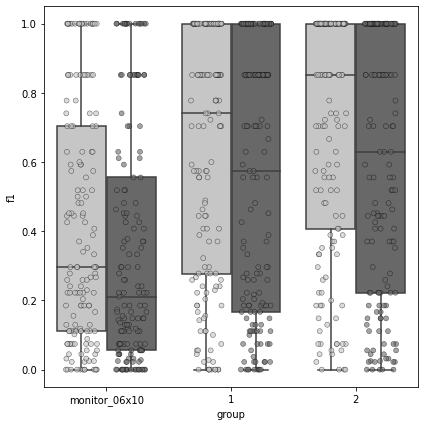

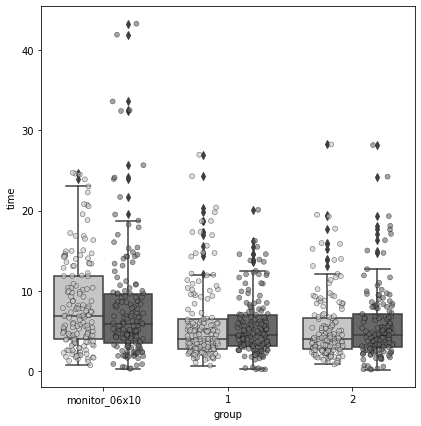

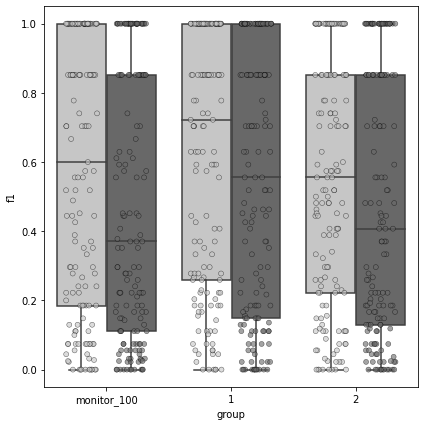

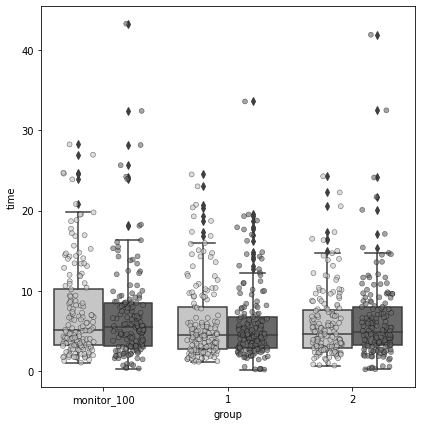

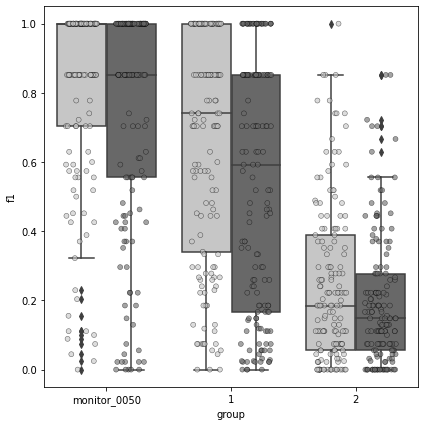

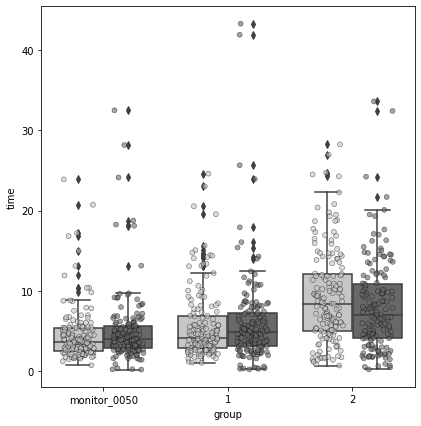

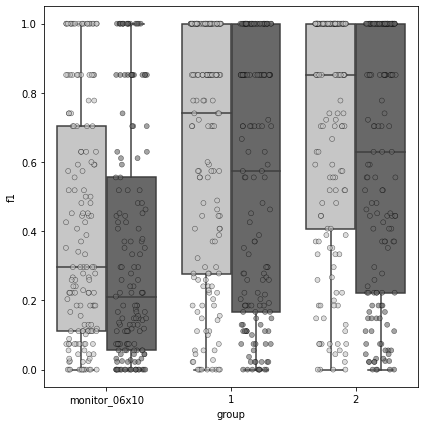

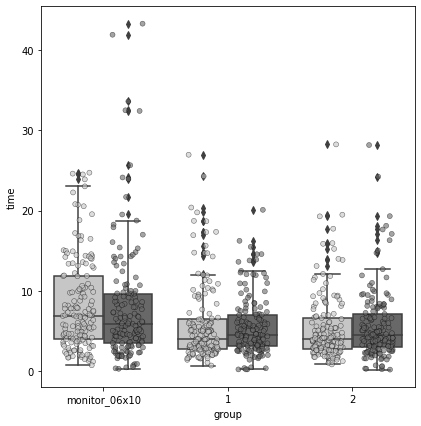

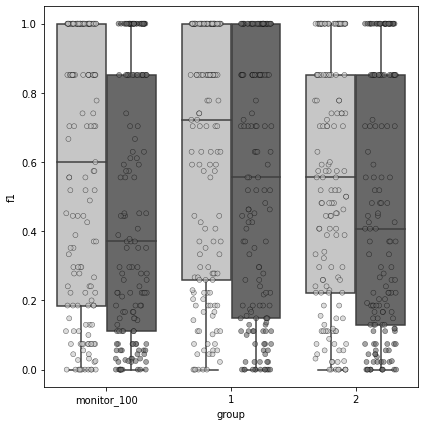

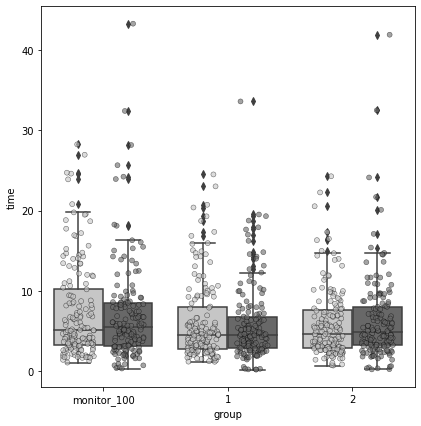

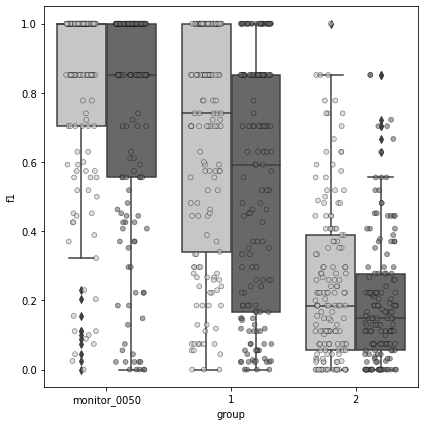

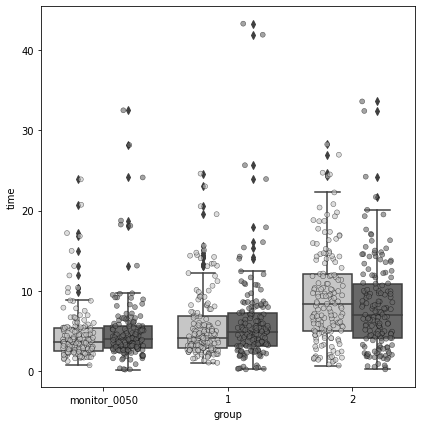

In [53]:
generate_all(df_annot)

In [54]:
import pulse2percept as p2p

In [55]:
df_annot

,subject,device,rho,lam,f1,time,hmd
0,1,headset_06x10,headset_100,headset_0050,0.518519,8.740615,headset
1,1,headset_06x10,headset_100,headset_1000,0.296296,6.829536,headset
2,1,headset_06x10,headset_100,headset_5000,0.074074,18.825656,headset
3,1,headset_06x10,headset_300,headset_0050,0.111111,20.734876,headset
4,1,headset_06x10,headset_300,headset_1000,0.222222,15.075710,headset
...,...,...,...,...,...,...,...
454,20,monitor_19x31,monitor_300,monitor_1000,0.851852,3.360114,monitor
455,20,monitor_19x31,monitor_300,monitor_5000,0.518519,3.768589,monitor
456,20,monitor_19x31,monitor_500,monitor_0050,1.000000,2.665365,monitor
457,20,monitor_19x31,monitor_500,monitor_1000,1.000000,3.080112,monitor


<AxesSubplot:xlabel='subject', ylabel='f1'>

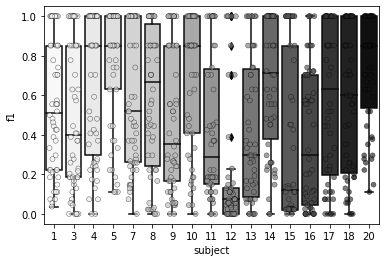

In [56]:
sns.boxplot(x='subject', y='f1', data=df_annot, palette='Greys')
sns.stripplot(x='subject', y='f1', data=df_annot, dodge=True, palette='Greys', jitter=.25, edgecolor='black', linewidth=.5, alpha=.6)


In [57]:
for subject in df_annot['subject'].unique():
    print(subject, ',', "{:.3f}".format(df_annot[df_annot['subject']==subject]['f1'].mean()),',', 
          "{:.3f}".format(df_annot[df_annot['subject']==subject]['f1'].std()), ',',
         "{:.3f}".format(df_annot[df_annot['subject']==subject]['time'].mean()), ',',
         "{:.3f}".format(df_annot[df_annot['subject']==subject]['time'].std()))

1 , 0.535 , 0.332 , 8.028 , 6.483
3 , 0.493 , 0.374 , 8.284 , 5.949
4 , 0.659 , 0.355 , 8.268 , 5.218
5 , 0.760 , 0.307 , 7.006 , 3.605
7 , 0.593 , 0.352 , 9.146 , 5.779
8 , 0.584 , 0.365 , 3.544 , 2.093
9 , 0.471 , 0.360 , 5.799 , 2.824
10 , 0.681 , 0.339 , 8.693 , 9.392
11 , 0.428 , 0.357 , 8.164 , 6.016
12 , 0.191 , 0.313 , 2.508 , 1.934
13 , 0.418 , 0.355 , 7.766 , 3.831
14 , 0.666 , 0.337 , 5.476 , 3.650
15 , 0.369 , 0.418 , 3.363 , 2.865
16 , 0.388 , 0.348 , 5.389 , 3.783
17 , 0.576 , 0.388 , 4.800 , 3.891
18 , 0.584 , 0.366 , 8.132 , 6.044
20 , 0.737 , 0.281 , 5.429 , 4.195


<AxesSubplot:xlabel='subject', ylabel='time'>

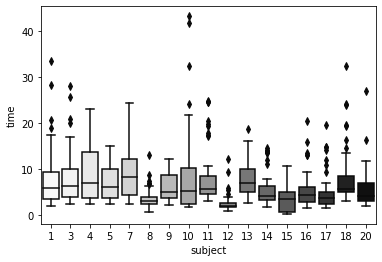

In [58]:
sns.boxplot(x='subject', y='time', data=df_annot, palette='Greys')

In [59]:
 rp.summary_cat(df_annot[df_annot['subject']==12]['f1'])

,Variable,Outcome,Count,Percent
0,f1,0.000000,15,27.78
1,,0.074074,7,12.96
2,,1.000000,5,9.26
3,,0.055556,4,7.41
4,,0.044444,4,7.41
5,,0.111111,4,7.41
6,,0.129630,2,3.70
7,,0.703704,2,3.70
8,,0.031746,2,3.70
9,,0.024691,1,1.85
